In [1]:
# python
import sys
import importlib
# columnar analysis
from coffea.nanoevents import NanoAODSchema
from coffea import processor
# local
sidm_path = str(sys.path[0]).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)
from sidm.tools import sidm_processor, utilities, scaleout
# always reload local modules to pick up changes during development
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()

In [2]:
#client = scaleout.make_dask_client("tls://localhost:8786")
#client

In [3]:
samples = [
    '2Mu2E_500GeV_5p0GeV_8p0mm',
    'TTJets',
]

In [4]:
for sample in samples:
    print(sample, utilities.get_xs(sample))

Signal not in xs cfg, assuming 1fb
2Mu2E_500GeV_5p0GeV_8p0mm 0.001
TTJets 471.7


In [5]:
fileset = utilities.make_fileset([samples[0]], "llpNanoAOD_v2", max_files=5, location_cfg="signal_2mu2e_v10.yaml")
fileset = utilities.make_fileset([samples[1]], "llpNanoAOD_v2", max_files=5, location_cfg="backgrounds.yaml", fileset=fileset)

runner = processor.Runner(
    #executor=processor.IterativeExecutor(),
    executor=processor.FuturesExecutor(),
    #executor=processor.DaskExecutor(client=client),
    schema=NanoAODSchema,
    #maxchunks=1,
    skipbadfiles=True,
)

channels = [
    "2mu2e",
]
p = sidm_processor.SidmProcessor(
    channels,
    ["muon_base"],
)

output = runner.run(fileset, treename='Events', processor_instance=p)
out = output["out"]

Output()

Output()

/opt/conda/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(


#--------------------------------------------------------------------------
#                         FastJet release 3.4.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


weighted hists
Signal not in xs cfg, assuming 1fb


In [6]:
for sample in samples:
    print(sample, out[sample]["metadata"])

2Mu2E_500GeV_5p0GeV_8p0mm {'n_evts': 21957}
TTJets {'n_evts': 196576}


In [7]:
print(samples[0])
out[samples[0]]["cutflow"][channels[0]].print_table()
print()
out[samples[0]]["cutflow"][channels[0]].print_table(unweighted=True)
print()
out[samples[0]]["cutflow"][channels[0]].print_table(fraction=True)
print()

2Mu2E_500GeV_5p0GeV_8p0mm
Signal not in xs cfg, assuming 1fb
cut name         individual cut N    all cut N
-------------  ------------------  -----------
No selection                 59.0         59.0
pass triggers                22.0         22.0
PV filter                    57.6         21.4
>=2 LJs                      11.7          4.8
2mu2e                        11.6          4.8

cut name         individual cut N    all cut N
-------------  ------------------  -----------
No selection              21957.0      21957.0
pass triggers              8184.0       8184.0
PV filter                 21419.0       7954.0
>=2 LJs                    4347.0       1785.0
2mu2e                      4334.0       1781.0

cut name         individual %    marginal %    cumulative %
-------------  --------------  ------------  --------------
No selection            100.0         100.0           100.0
pass triggers            37.3          37.3            37.3
PV filter                97.5          

In [8]:
print(samples[1])
out[samples[1]]["cutflow"][channels[0]].print_table()
print()
out[samples[1]]["cutflow"][channels[0]].print_table(unweighted=True)
print()
out[samples[1]]["cutflow"][channels[0]].print_table(fraction=True)
print()

TTJets
cut name         individual cut N    all cut N
-------------  ------------------  -----------
No selection           27830300.0   27830300.0
pass triggers            471445.6     471445.6
PV filter              27776076.7     470596.2
>=2 LJs                  157714.8       3114.7
2mu2e                     13449.7       2831.5

cut name         individual cut N    all cut N
-------------  ------------------  -----------
No selection             196576.0     196576.0
pass triggers              3330.0       3330.0
PV filter                196193.0       3324.0
>=2 LJs                    1114.0         22.0
2mu2e                        95.0         20.0

cut name         individual %    marginal %    cumulative %
-------------  --------------  ------------  --------------
No selection            100.0         100.0           100.0
pass triggers             1.7           1.7             1.7
PV filter                99.8          99.8             1.7
>=2 LJs                   0.6    

In [9]:
output.keys()

dict_keys(['out', 'processed', 'exception'])

In [10]:
output["processed"]

{WorkItem(dataset='2Mu2E_500GeV_5p0GeV_8p0mm', filename='root://xcache//store/group/lpcmetx/SIDM/ULSignalSamples/2018_v10/BsTo2DpTo2Mu2e/CutDecayFalse_SIDM_BsTo2DpTo2Mu2e_MBs-500_MDp-5p0_ctau-8p0_v3/LLPnanoAODv2/CutDecayFalse_SIDM_BsTo2DpTo2Mu2e_MBs-500_MDp-5p0_ctau-8p0_v3_part-0.root', treename='Events', entrystart=0, entrystop=4364, fileuuid=b'\xac\xd8R\xc6\xbf\x88\x11\xef\x9b\xf4[\x15\xe6\x9b\xbe\xef', usermeta={}),
 WorkItem(dataset='2Mu2E_500GeV_5p0GeV_8p0mm', filename='root://xcache//store/group/lpcmetx/SIDM/ULSignalSamples/2018_v10/BsTo2DpTo2Mu2e/CutDecayFalse_SIDM_BsTo2DpTo2Mu2e_MBs-500_MDp-5p0_ctau-8p0_v3/LLPnanoAODv2/CutDecayFalse_SIDM_BsTo2DpTo2Mu2e_MBs-500_MDp-5p0_ctau-8p0_v3_part-1.root', treename='Events', entrystart=0, entrystop=4319, fileuuid=b'\xf4\x94\x97\xe0\xbfz\x11\xef\x8c\x0f\x9b\x15\xe6\x9b\xbe\xef', usermeta={}),
 WorkItem(dataset='2Mu2E_500GeV_5p0GeV_8p0mm', filename='root://xcache//store/group/lpcmetx/SIDM/ULSignalSamples/2018_v10/BsTo2DpTo2Mu2e/CutDecayFalse_

In [11]:
out[samples[0]]["hists"]

{'muon_n': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(10, 0, 10, name='muons_n', label='Number of PF Muons'),
   storage=Weight()) # Sum: WeightedSum(value=4.78567, variance=0.0128594),
 'muon_pt': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 500, name='muons_pt', label='PF Muon $p_T$'),
   storage=Weight()) # Sum: WeightedSum(value=9.29995, variance=0.0249896),
 'muon_dxy': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 100, name='muons_dxy', label='PF Muon $d_0$'),
   storage=Weight()) # Sum: WeightedSum(value=4.65132, variance=0.0124984) (WeightedSum(value=9.29995, variance=0.0249896) with flow),
 'muon_eta_phi': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(50, -3, 3, name='muons_eta', label='PF Muon $\\eta$'),
   Regular(50, -3.14159, 3.14159, name='muons_phi', label='PF Muon $\\phi$'),
   storage=Weight()) # Sum: WeightedSum(value=9.29995, variance=0.0249896),
 'muon_absD0': Hist(
   StrCategory(['2mu2e'],

In [12]:
out[samples[1]]["hists"]

{'muon_n': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(10, 0, 10, name='muons_n', label='Number of PF Muons'),
   storage=Weight()) # Sum: WeightedSum(value=2831.51, variance=400871),
 'muon_pt': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 500, name='muons_pt', label='PF Muon $p_T$'),
   storage=Weight()) # Sum: WeightedSum(value=7503.49, variance=1.06231e+06),
 'muon_dxy': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 100, name='muons_dxy', label='PF Muon $d_0$'),
   storage=Weight()) # Sum: WeightedSum(value=3964.11, variance=561220) (WeightedSum(value=7503.49, variance=1.06231e+06) with flow),
 'muon_eta_phi': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(50, -3, 3, name='muons_eta', label='PF Muon $\\eta$'),
   Regular(50, -3.14159, 3.14159, name='muons_phi', label='PF Muon $\\phi$'),
   storage=Weight()) # Sum: WeightedSum(value=7503.49, variance=1.06231e+06),
 'muon_absD0': Hist(
   StrCategory(['2mu2e'],

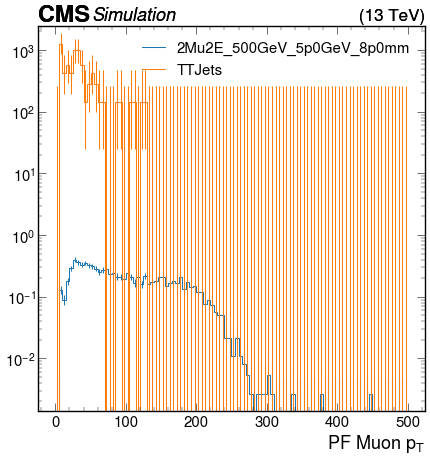

In [13]:
for sample in samples:
    utilities.plot(out[sample]["hists"]["muon_pt"][channels[0], :])
    plt.yscale("log")
plt.legend(samples)

In [14]:
p_unweighted = sidm_processor.SidmProcessor(
    channels,
    ["muon_base"],
    unweighted_hist=True,
)

output_unweighted = runner.run(fileset, treename='Events', processor_instance=p_unweighted)
out_unweighted = output_unweighted["out"]

Output()

/opt/conda/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(


#--------------------------------------------------------------------------
#                         FastJet release 3.4.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


unweighted hists


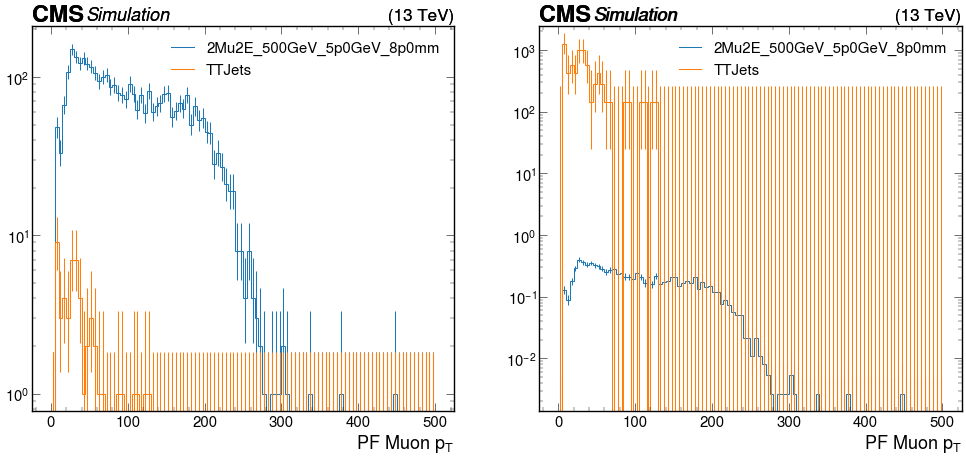

In [15]:
plt.subplots(1, 2, figsize=(2*12, 10))
plt.subplot(1, 2, 1)
for sample in samples:
    utilities.plot(out_unweighted[sample]["hists"]["muon_pt"][channels[0], :])
    plt.yscale("log")
plt.legend(samples)
plt.subplot(1, 2, 2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["muon_pt"][channels[0], :])
    plt.yscale("log")
plt.legend(samples)

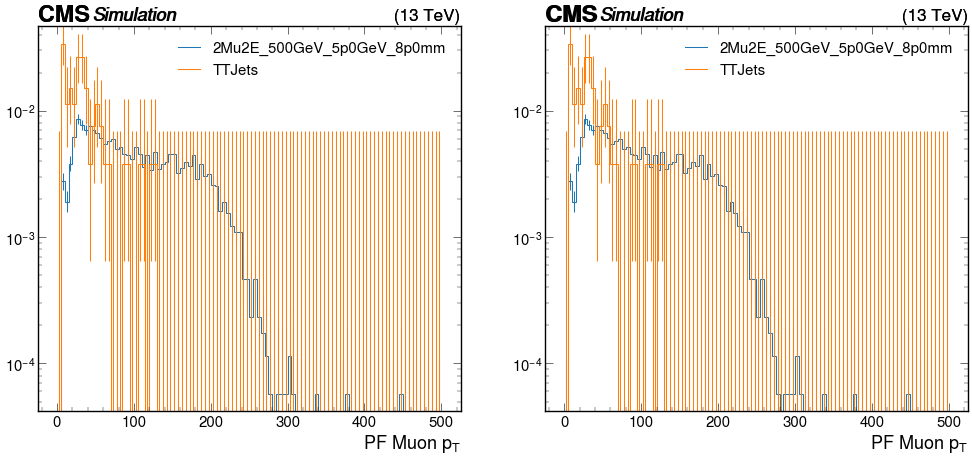

In [16]:
plt.subplots(1, 2, figsize=(2*12, 10))
plt.subplot(1, 2, 1)
for sample in samples:
    utilities.plot(out_unweighted[sample]["hists"]["muon_pt"][channels[0], :], density=True)
    plt.yscale("log")
plt.legend(samples)
plt.subplot(1, 2, 2)
for sample in samples:
    utilities.plot(out[sample]["hists"]["muon_pt"][channels[0], :], density=True)
    plt.yscale("log")
plt.legend(samples)

In [17]:
out_unweighted[samples[0]]["hists"]

{'muon_n': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(10, 0, 10, name='muons_n', label='Number of PF Muons'),
   storage=Weight()) # Sum: WeightedSum(value=1781, variance=1781),
 'muon_pt': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 500, name='muons_pt', label='PF Muon $p_T$'),
   storage=Weight()) # Sum: WeightedSum(value=3461, variance=3461),
 'muon_dxy': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 100, name='muons_dxy', label='PF Muon $d_0$'),
   storage=Weight()) # Sum: WeightedSum(value=1731, variance=1731) (WeightedSum(value=3461, variance=3461) with flow),
 'muon_eta_phi': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(50, -3, 3, name='muons_eta', label='PF Muon $\\eta$'),
   Regular(50, -3.14159, 3.14159, name='muons_phi', label='PF Muon $\\phi$'),
   storage=Weight()) # Sum: WeightedSum(value=3461, variance=3461),
 'muon_absD0': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 500

In [18]:
out_unweighted[samples[1]]["hists"]

{'muon_n': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(10, 0, 10, name='muons_n', label='Number of PF Muons'),
   storage=Weight()) # Sum: WeightedSum(value=20, variance=20),
 'muon_pt': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 500, name='muons_pt', label='PF Muon $p_T$'),
   storage=Weight()) # Sum: WeightedSum(value=53, variance=53),
 'muon_dxy': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 100, name='muons_dxy', label='PF Muon $d_0$'),
   storage=Weight()) # Sum: WeightedSum(value=28, variance=28) (WeightedSum(value=53, variance=53) with flow),
 'muon_eta_phi': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(50, -3, 3, name='muons_eta', label='PF Muon $\\eta$'),
   Regular(50, -3.14159, 3.14159, name='muons_phi', label='PF Muon $\\phi$'),
   storage=Weight()) # Sum: WeightedSum(value=53, variance=53),
 'muon_absD0': Hist(
   StrCategory(['2mu2e'], name='channel'),
   Regular(100, 0, 500, name='muons_dxy', 